In [1]:
pip install matplotlib numpy scipy pandas ipywidgets plotly

Note: you may need to restart the kernel to use updated packages.


In [1]:
#%%imports and initial parameters
import matplotlib.pyplot as plt
import numpy as np
import os, os.path
from scipy.special import wofz
from scipy.optimize import curve_fit
from pandas import DataFrame, read_csv
import ipywidgets as widgets
import plotly.graph_objects as go

In [3]:
"""Parameters"""
mainDirectory = os.getcwd() #remember: / is the separator here
materialIn = widgets.Text(value='Silicon',
       description='Material:', )
rangeSpec = range(0, 670) #0-1015 = full range (670)
ib = rangeSpec.start #the starting row of the specified data range in TXT file
ie = rangeSpec.stop #the ending row of the specified data range in TXT file
confHRamanShiftIn = widgets.FloatText(
    value=520,
    description='Peak Raman Shift \(cm-1\):',
    disabled=False) #cm-1
plotBoolIn = widgets.Checkbox(
           description='Plots',) #plot figures in FWHM
lorGauIn = widgets.RadioButtons(
    options=['Lorentzian', 'Gaussian', 'Voigtian'],
     value='Gaussian',
    description='Pizza topping:',
    disabled=False) #Lorentzian = 0 and Gaussian = 1 and Voigt = 2 (Solid Gaussian, Liquid Voigtian, Gas Loretzian)
box = widgets.VBox([materialIn, confHRamanShiftIn, plotBoolIn, lorGauIn])
box

In [4]:
material = materialIn.value
confHRamanShift = confHRamanShiftIn.value
plotBool = int(plotBoolIn.value)
lorGau = lorGauIn.index

In [5]:
#%% Functions

def DataFileCleaner(file):
    
#    #Single Files in one file
#    data = read_csv(file, sep="\t", header = None)
#    data = data.drop([0], axis = 0)
#    data = data.drop([3,4], axis = 1)
#    data.columns = ['T','RS', 'I']    
    
#    #Single Files
#    data = read_csv(file, sep="\t", header = None)
#    data = data.drop([0], axis = 0)
#    data = data.drop([2], axis = 1)
#    data.columns = ['RS', 'I']    
    
    #depth
    data = read_csv(file)
    data = data.drop([0], axis = 0)
    data = data.drop([3,4], axis = 1)
    data.columns = ['Z', 'RS', 'I']
    
    
#    #MAP
#    data = read_csv(file, sep="\t", header = None)
#    data = data.drop([0], axis = 0)
#    data = data.drop([4,5,6], axis = 1)
#    data.columns = ['X', 'Y', 'RS', 'I']
    
## single File
#    lineList = [] #Data
#    f = open(file, 'r')  # We need to re-open the file
#    #data = f.read()
#    for line in f:
#        info = line
#        info = info.strip() #removing leading and following white spaces
#        info = re.split('\\t', info)
#        if(info[0] != '#Time'): #keep the title line out
#           lineList.append(list(map(float, info))) #turn the string numbers to float in the list itself
#    lineList.reverse() #the file is high to low originally    
#    b = ib    
#    while b < ie:
#        lineList[b].remove(lineList[b][0]) #the zeros
##        if len(lineList[b]) == 5:
##            lineList[b].remove(lineList[b][3]) 
#        b += 1
#    lineListCleaned = np.array(lineList[ib:ie]).astype(float)
    return(data) #lineListCleaned

def Gauss(x, a, x0, sigmaVal):
    return(a * np.exp(-(x - x0)**2 / (2 * sigmaVal**2)))
    
def Lorentzian( x, a, x0, gam ): #x = x range, a = amplitude, x0 = center, gam = width
    return(a * gam**2 / ( gam**2 + ( x - x0 )**2))

def Voigt(x, a, x0, sigmaVal, gamma):
    """
    Return the Voigt line shape at x with Lorentzian component HWHM gamma
    and Gaussian component HWHM alpha.

    """

    return(a * np.real(wofz((x - x0 + 1j*gamma)/sigmaVal/np.sqrt(2))) / sigmaVal /np.sqrt(2*np.pi))

def FWHMIndices(array, rShiftsVec, peakValue):
    index = int(np.where(array == max(array))[0])
    HM = peakValue/2
    jj = 0
    xUp = []
    indicesUp = []
    for intensityVal in array[index:]:
        xUp.append(np.abs(array[index+jj] - HM)) #going right from peak
        indicesUp.append(index+jj)
        jj+=1 
    
    jj = 0    
    xDown = []    
    indicesDown = []
    for intensityVal in array[:index]:
        xDown.append(np.abs(array[index-jj] - HM)) #going left from peak
        indicesDown.append(index-jj)
        jj+=1
        
    upperLimIndex = indicesUp[xUp.index(min(xUp))]
    lowerLimIndex = indicesDown[xDown.index(min(xDown))]
    
    return(upperLimIndex, lowerLimIndex)
     

In [27]:
"""BODY"""
#%%Extracting number and name of the files
os.chdir(mainDirectory)
if not os.path.exists('Data'):
    os.makedirs('Data')
os.chdir(mainDirectory + '/Data')
dummyNameFiles = [name for name in os.listdir(os.curdir) if os.path.isfile(os.path.join(os.curdir, name))] 
if len(dummyNameFiles) < 1:
    raise ValueError('The number of files with the chosen material (of all concentrations) is 0!\
                     Please check the chosen material name! and/or the \'Data\' directory.') 
start_fileName = material
fileNames = [inName for inName in dummyNameFiles if material in inName]
numFiles = len(fileNames)

In [28]:
#%%r Inputing the Data

os.chdir(mainDirectory + '/Data')
data = read_csv(fileNames[0], delim_whitespace=True, header = None)
data = data.drop([0], axis = 0)
data = data.astype(float)
#data = data.drop([3,4], axis = 1)
data.columns = ['Z', 'RS', 'I']
cleanedFileData = data#DataFileCleaner(fileNames[0]) #Function Call
#        numSpectra = len(cleanedFileData['Y'].unique())*len(cleanedFileData['Y'].unique()) # number of spectra 
numSpectra = len(cleanedFileData['Z'].unique()) # number of spectra 

/srv/conda/envs/notebook/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning:

Columns (0,1,2) have mixed types.Specify dtype option on import or set low_memory=False.



In [29]:
#%% Shaping the data
"""multi-level labeling of the data"""
#row_ix = MultiIndex.from_product([list(cleanedFileData['Z'].unique()),\
#                                  list(cleanedFileData['RS'][0:int(data.shape[0]/numSpectra)])])
#data = data.set_index(row_ix)
#data = data.drop(['Z','RS'], axis = 1)

dataDim = (numSpectra, len(rangeSpec)) 

all_Data = cleanedFileData['I'].values.reshape(dataDim).astype(float).transpose()
lambs = cleanedFileData['RS'].values.reshape(dataDim).astype(float).transpose()
#        labels = sorted(     np.ndarray(cleanedFileData['X']).reshape(dataDim)    , key=lambda tup: tup[1])
labels = cleanedFileData['Z'].values.reshape(dataDim).astype(float).transpose()

In [30]:
#%%extracting the peak information

indFinderVec = [abs(val - confHRamanShift) for val in lambs[:,0]]
peakIndexExp = indFinderVec.index(min(indFinderVec))
tol = 3 #tolerance

#fileIndex = np.linspace(0, multi_all_Data.shape[0]-1, multi_all_Data.shape[0], dtype=int)
maxPeakDataFrame = DataFrame(all_Data[peakIndexExp-tol:peakIndexExp+tol,:])

maxPeak = maxPeakDataFrame.max(axis=0) #intensity

if (maxPeak.loc[0] == maxPeakDataFrame.loc[0].loc[0]).any() or\
    (maxPeak.loc[0] == maxPeakDataFrame.loc[0].iloc[-1]).any():
    tol = 5
    maxPeakDataFrame = DataFrame(all_Data[peakIndexExp-tol:peakIndexExp+tol,:]) #enlarging the window to contain possible peak
    maxPeak = maxPeakDataFrame.max(axis=0) #intensity - axis: for 40 spectra, level: to separate files

indFinderCompar = maxPeakDataFrame == maxPeak
peakIndices = DataFrame([(indFinderCompar[indFinderCompar[zw] == True].index - tol + peakIndexExp)[0]\
             for zw in np.linspace(0,maxPeakDataFrame.shape[1]-1,maxPeakDataFrame.shape[1],dtype=int)])

peakRShifts = DataFrame(lambs[peakIndices,0] ,columns = ['RShift'])
peakData = peakRShifts.assign(Intensity = DataFrame(maxPeak))

Text(0, 0.5, 'Intensity [counts]')

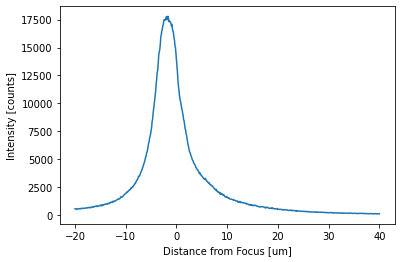

In [31]:
#%%plot results
plt.plot(labels[0,:], peakData['Intensity']) #labels[0,:] - (labels[0,0]+25) if 0 was not 0
plt.xlabel("Distance from Focus [um]")
plt.ylabel("Intensity [counts]")

In [32]:
# Create figure

maxBell = max(peakData['Intensity']) #intensity
bellPeakIndex = peakData['Intensity'].index[peakData['Intensity'] == maxBell][0]
if len(labels[0,:]) - bellPeakIndex < bellPeakIndex:
    removeNum = bellPeakIndex - (len(labels[0,:]) - bellPeakIndex)
    x = labels[0,removeNum:] #labels[0,removeNum:] - (labels[0,0]+25) if 0 was not 0, -25 is the initial point
    y = peakData['Intensity'][removeNum:]
else:
    removeNum = - bellPeakIndex + (len(labels[0,:]) - bellPeakIndex)
    x = labels[0,:-removeNum] - (labels[0,0]+25)
    y = peakData['Intensity'][:-removeNum]   

fig = go.Figure()

# Add traces, one for each slider step
for step in np.arange(0, int(len(x)//2)-1, 1):
    fig.add_trace(
        go.Scatter(
            visible=False,
            line=dict(color="#00CED1", width=6),
            name="limNumber = " + str(step),
            x=x[step:-(step+1)],
            y=y[step:-(step+1)]))

# Make 1st trace visible
fig.data[0].visible = True

# Create and add slider
steps = []
for i in range(len(fig.data)):
    step = dict(
        method="update",
        args=[{"visible": [False] * len(fig.data)},
              {"title": "Select the limitation for the peak: " + str(i * 2) + str(' datapoints removed')}],  # layout attribute
    )
    step["args"][0]["visible"][i] = True  # Toggle i'th trace to "visible"
    steps.append(step)

sliders = [dict(
    active=0,
    currentvalue={"prefix": "Number of datapoints removed (each side): "},
    pad={"t": 50},
    steps=steps
)]

fig.update_layout(
    sliders=sliders
)

fig.show()
limNumIn = widgets.IntText(
    value=0,
    description='LimNum:',
    disabled=False) # the user chooses a number of datapoints to be removed
limNumIn

IntText(value=0, description='LimNum:')

In [33]:
limNum = limNumIn.value
x = x[limNum:-(limNum+1)]
y = y[limNum:-(limNum+1)]

In [34]:
mean = sum(x * y) / sum(y)
sigmaVal = np.sqrt(sum(y * (x - mean)**2) / sum(y))
voigtFailSafeSwitch = 0

if lorGau == 1: # Gaussian = 1, Lorentzian = 0
    try:
        popt,pcov = curve_fit(Gauss, x, y, p0=[maxBell, mean, sigmaVal])
        fittedCurve = Gauss(x, *popt) 
        residuals = y- Gauss(x, *popt)
        fitType = "Gaussian"
    except:
        print('The Gaussian could not be fitted to this data')
elif lorGau == 0:
    try:
        popt,pcov = curve_fit(Lorentzian, x, y, p0=[maxBell, mean, sigmaVal])
        fittedCurve = Lorentzian(x, *popt) 
        residuals = y- Lorentzian(x, *popt)
        fitType = "Lorentzian"
    except:
        print('The Lorentzian could not be fitted to this data')
elif lorGau == 2:
    try:
        popt,pcov = curve_fit(Voigt, x, y, p0=[maxBell, mean, sigmaVal])
        fittedCurve = Voigt(x, *popt)
        residuals = y- Voigt(x, *popt)
        fitType = "Voigtian"
    except:
        print('The Voigt could not be fitted to this data')
        popt,pcov = curve_fit(Gauss, x, y, p0=[maxBell, mean, sigmaVal])
        fittedCurve = Gauss(x, *popt) 
        residuals = y- Gauss(x, *popt)
        fitType = "Gaussian"
        voigtFailSafeSwitch = 1
else:
    raise ValueError('Wrong function given to fit! use Voigt = 2, Gaussian = 1, Lorentzian = 0')
    
if voigtFailSafeSwitch == 1:
    print('A Gaussian was fitted instead.')
    
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y-np.mean(y))**2)
r_squared = 1 - (ss_res / ss_tot) 

uplim, lowLim = FWHMIndices(fittedCurve, x, maxBell)
upperLimWN = x[uplim]
lowerLimWN = x[lowLim]
FWHM = round(upperLimWN-lowerLimWN, 1)

if plotBool == 1:
    plt.title(start_fileName + '-R-Squared: ' + str(round(r_squared,3)))  
    plt.plot(x,y, label='Intensity Trace')
    plt.plot(x, fittedCurve, 'r-', label=fitType + ' Fit')
    plt.xlabel('Distance from Focus (um)')
    plt.ylabel('Peak Intensity (# counts)')
    plt.hlines(y = maxBell/2.0, \
               xmin = lowerLimWN, xmax = upperLimWN,\
               label= 'Half Maximum Line',\
               color = 'black')
    plt.text((upperLimWN + lowerLimWN)/2.0, maxBell/1.9, str(FWHM)+' um', horizontalalignment='center')
    plt.legend(bbox_to_anchor=(0.5,-0.15), loc="upper center", borderaxespad=0)

    currdir = os.curdir
    os.chdir(mainDirectory)
    if not os.path.exists('Figures'):
        os.makedirs('Figures')
    os.chdir(mainDirectory + '/Figures')    
    figName = "ResultingFig_" + fileNames[0][:-4] + '_' + fitType  #this i should be the same for all the algorithms!
    plt.savefig(figName, dpi=300, bbox_inches = "tight")
    os.chdir(currdir)
    plt.close();
    
#final output
print('The FWHM and hence the height of confocality for\n', fileNames[0], '\n is:', FWHM)

The FWHM and hence the height of confocality for
 Silicon_PURE_Standard_100percent_DepthScan_0,5s_Center750cm-1_X50_-20to+40um0,1step_2.txt 
 is: 6.0
